In [1]:
#Imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm.auto import tqdm
import glob
import imageio
import natsort
import cv2
from matplotlib import gridspec
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from IPython import display

import tensorflow as tf
import keras
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorboard import program as tbprogram
import shutil

print(keras.__version__)
print(tf.__version__)

import importlib
sys.path.insert(1,'../src')
import utils
import radar_utils as ru
import p2go_radar_utils as pu
import nn_utils as nn
importlib.reload(utils)
importlib.reload(ru)
importlib.reload(nn)
importlib.reload(pu)

from IPython import display

LOGDIR = 'summaries'
if os.path.isdir(LOGDIR):
    shutil.rmtree(LOGDIR)
os.mkdir(LOGDIR)
tb = tbprogram.TensorBoard()
tb.configure(argv=[None, '--logdir', LOGDIR])
tb.launch()

C:\Users\mdiyan\envs\tf-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1

2.6.0
2.6.0


'http://localhost:6006/'

### 1.1 Load radar metadata

In [2]:
#Load metadata
samples_per_chirp = 128 #number of samples
chirps_per_burst = 16
T_c = (1/2000) #up chirp time = 1/chirp rate
B = 1e9 #bandwidth = 61GHz - 59Ghz
c = 3e8 
f_tx = 60e9 #tranmission frequency = 60GHz
wavelength = c/f_tx
spacing = 2.5e-3 #spacing between receiver antennas in m

#Load range and frequency samples corresponding to radar metadata
soli_rang = ru.range_freqsamples()
soli_vel = ru.velocity_freqsamples()

p2go_rang = pu.range_freqsamples()
p2go_vel = pu.velocity_freqsamples()

### 1.2 Load acquisition

In [3]:
importlib.reload(pu)
dataset = r'for_Muhammad\data'

#images = np.zeros((3, 3600, 54, 96))
# images = np.zeros((3, 9000, 48, 64))
# soli_iq = np.zeros((3, 9000, 3, 128),dtype=np.complex64)
# soli_rp = np.zeros((3, 9000, 3, 64),dtype=np.complex64)
# soli_crd = np.zeros((3, 9000, 3, 64, 16),dtype=np.complex64)
# p2go_iq = np.zeros((3, 9000, 2, 128),dtype=np.complex64)
# p2go_rp = np.zeros((3, 9000, 2, 64),dtype=np.complex64)
# p2go_crd = np.zeros((3, 9000, 2, 64, 16),dtype=np.complex64)

# #Load the crd-image pairs
#['1-10','11-20','21-30','31-40','41-50','51-60']
# for i,j in enumerate(['1-10','11-20','21-30','31-40','41-50','51-60']):
#     print(i)
#     images[i*10:(i+1)*10] = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\images_resized_{}.npy".format(dataset,j), allow_pickle=True).astype('float32')
#     soli_crd[i*10:(i+1)*10] = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\soli_crd_data_resampled_no_declutter_{}.npy".format(dataset,j), allow_pickle=True)
#     soli_rp[i*10:(i+1)*10] = np.abs(np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\soli_rp_data_resampled_{}.npy".format(dataset,j), allow_pickle=True))
#     soli_iq[i*10:(i+1)*10] = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\soli_iq_data_resampled_{}.npy".format(dataset,j), allow_pickle=True)
#     p2go_crd[i*10:(i+1)*10] = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\p2go_crd_data_resampled_no_declutter_{}.npy".format(dataset,j), allow_pickle=True)
#     p2go_rp[i*10:(i+1)*10] = np.abs(np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\p2go_rp_data_resampled_{}.npy".format(dataset,j), allow_pickle=True))
#     p2go_iq[i*10:(i+1)*10] = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\01_data\p2go_iq_data_resampled_{}.npy".format(dataset,j), allow_pickle=True)
j=r'0'    
images = np.load(r"C:\Users\Muhammad Diyan\OneDrive - University of Glasgow\Shared\2022-05-11-1600\preprocessed_data\images_resized.npy", allow_pickle=True).astype('float32')
soli_crd = np.load(r"C:\Users\Muhammad Diyan\OneDrive - University of Glasgow\Shared\2022-05-11-1600\preprocessed_data\crd_data_resampled_no_declutter.npy", allow_pickle=True)
soli_iq= np.abs(np.load(r"C:\Users\Muhammad Diyan\OneDrive - University of Glasgow\Shared\2022-05-11-1600\preprocessed_data\iq_data_resampled.npy", allow_pickle=True))
soli_rp = np.load(r"C:\Users\Muhammad Diyan\OneDrive - University of Glasgow\Shared\2022-05-11-1600\preprocessed_data\rp_data_resampled.npy", allow_pickle=True)
# p2go_crd = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\{}\01_data\p2go_crd_data_resampled_no_declutter_{}.npy".format(dataset,j), allow_pickle=True)
# p2go_rp = np.abs(np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\{}\01_data\p2go_rp_data_resampled_{}.npy".format(dataset,j), allow_pickle=True))
# p2go_iq = np.load(r"C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\{}\01_data\p2go_iq_data_resampled_{}.npy".format(dataset,j), allow_pickle=True)
     
# soli_crd_dec = soli_crd_dec.reshape(-1,3,64,16)    
soli_crd = soli_crd.reshape(-1,3,64,16)
soli_rp = soli_rp.reshape(-1,3,64)
soli_iq = soli_iq.reshape(-1,3,128).astype('float32')
# p2go_crd = p2go_crd.reshape(-1,2,64,16)
# p2go_rp = p2go_rp.reshape(-1,2,64)
# p2go_iq = p2go_iq.reshape(-1,2,128)
images = images.reshape((3600,54,96))
imagess = np.zeros((len(images),48,64))
for i in range(len(images)):
    imagess[i] = cv2.resize(images[i],(64,48))
images = imagess
soli_aoa = ru.get_aoa_data(soli_crd)


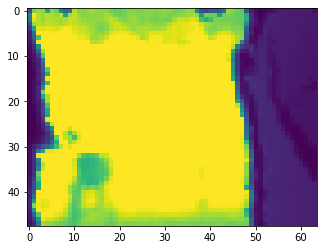

In [4]:
plt.imshow(images[0])

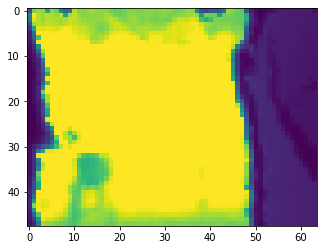

In [5]:
plt.imshow(imagess[0],)

### 1.3 Reformat the input data

In [6]:
importlib.reload(nn)
input_format = r'ard_aoa_aoa'
print(soli_crd.shape)

(3600, 3, 64, 16)


In [7]:
importlib.reload(nn)
soli_data_prep = nn.Data_prep(soli_crd,soli_rp,soli_iq,images,'soli')
soli_x_train,soli_x_val,soli_x_test,soli_y_train,soli_y_val,soli_y_test = soli_data_prep.ard_aoa_aoa_data_prep(0,3400,3500,3600,thresh=0.0,windowed=False,window=10,dataset_interval=0,step=3) #i keep the data prep separate so i don't forget steps when i change things
#soli_x_train,soli_x_val,soli_x_test,soli_y_train,soli_y_val,soli_y_test = soli_data_prep.iq_data_prep(0,8000,8500,9000,windowed=False,window=15,dataset_interval=3600,step=3) #i keep the data prep separate so i don't forget steps when i change things

max_depth = soli_data_prep.max_depth

print('Max depth in image dataset:',max_depth,'m\n',
      soli_x_train.shape,'\n',
      soli_x_val.shape,'\n',
      soli_x_test.shape,'\n',
      soli_y_train.shape,'\n',
      soli_y_val.shape,'\n',
      soli_y_test.shape)

Max depth in image dataset: 3.69921875 m
 (3400, 3, 64, 16) 
 (100, 3, 64, 16) 
 (100, 3, 64, 16) 
 (3400, 1, 48, 64) 
 (100, 1, 48, 64) 
 (100, 1, 48, 64)


In [8]:
# importlib.reload(nn)
# p2go_data_prep = nn.Data_prep(p2go_crd,p2go_rp,p2go_iq,p2go_images,'p2go')
# p2go_x_train,p2go_x_val,p2go_x_test,p2go_y_train,p2go_y_val,p2go_y_test = p2go_data_prep.ard_aoa_data_prep_p2go(0,8000,8500,9000,thresh=0.4,windowed=False,window=10,dataset_interval=0,step=3) #i keep the data prep separate so i don't forget steps when i change things
# #p2go_x_train,p2go_x_val,p2go_x_test,p2go_y_train,p2go_y_val,p2go_y_test = p2go_data_prep.iq_data_prep_p2go(0,8000,8500,9000,windowed=False,window=15,dataset_interval=3600,step=3) #i keep the data prep separate so i don't forget steps when i change things

# max_depth = p2go_data_prep.max_depth

# print('Max depth in image dataset:',max_depth,'m\n',
#       p2go_x_train.shape,'\n',
#       p2go_x_val.shape,'\n',
#       p2go_x_test.shape,'\n',
#       p2go_y_train.shape,'\n',
#       p2go_y_val.shape,'\n',
#       p2go_y_test.shape)

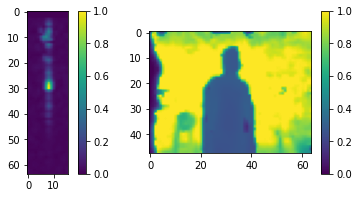

In [9]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(soli_x_test[50,0,:].astype('float32'))
plt.colorbar()
# plt.subplot(132)
# plt.imshow(p2go_x_test[160,0,:].astype('float32'))
plt.subplot(122)
plt.imshow(soli_y_test[50,0])
plt.colorbar()
plt.show()

In [10]:
# #Confirm sync
# for i in range(1000):
#     plt.figure(figsize=(8,3),dpi=50)
#     plt.subplot(121)
#     plt.imshow(np.abs(soli_crd[i,2]),cmap='jet',aspect='auto')
#     plt.subplot(122)
#     plt.imshow(soli_images[i].astype('float32'),cmap='jet')#,vmax=10)
#     #plt.colorbar()
#     #plt.show()
#     plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\03_results\timing\img{}.png'.format(i))
#     plt.close()

In [11]:
# #In depth check
# thresh = 0.02
# importlib.reload(utils)
# for j,co in enumerate(np.hstack((range(0,200),range(3000,3200),range(8000,8200)))):
#     co = int(co)
#     fig = utils.plot_ard_angle_image_data(
#                                   crd=soli_crd_dec,
#                                   aoa=soli_aoa,
#                                   images=soli_images[:,:,:],
#                                   co=co,
#                                   thresh=0.4,
#                                   rang=soli_rang,
#                                   vel=soli_vel,
#                                   max_depth=max_depth)
#     plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\03_results\timing\img{}.png'.format(j))
#     plt.close()
#     #plt.show()

### 1.3 Train 
ground truth radar > IM > predicted depth image > FM > predicted radar
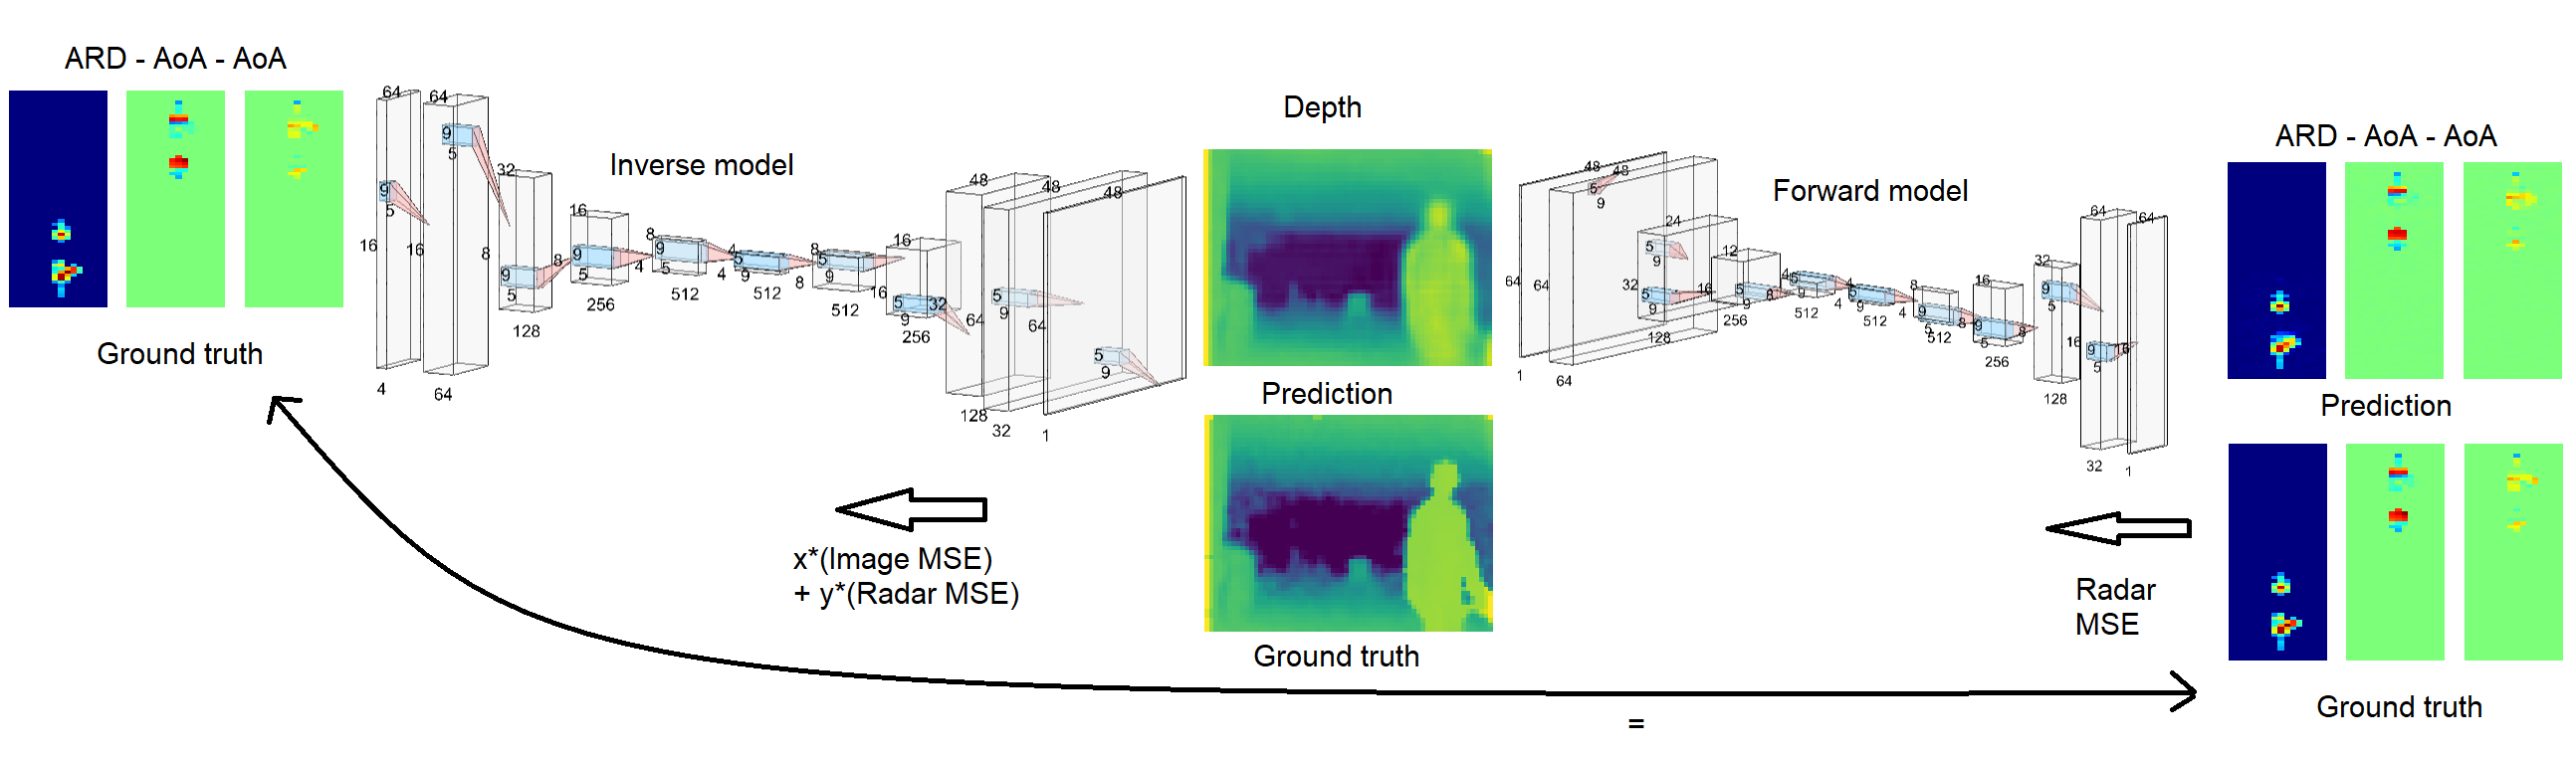

In [12]:
import inverse_forward_models_1
importlib.reload(inverse_forward_models_1)

IM = inverse_forward_models_1.inverse_model(soli_x_train[0].shape)     
FM = inverse_forward_models_1.forward_model(soli_y_train[0].shape)    
IM.summary()
FM.summary()

adam = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
mean_squared_error = tf.keras.losses.MeanSquaredError()

def inverse_loss(radar_true, image_true):
    alpha = 10
    beta = 1
    return alpha*mean_squared_error(radar_true,FM(IM(radar_true))) + beta*mean_squared_error(image_true,IM(radar_true))

def forward_loss(radar_true, image_true):
    return mean_squared_error(radar_true,FM(IM(radar_true)))

@tf.function
def train_step(radar_true, image_true):
    with tf.GradientTape() as inverse_tape, tf.GradientTape() as forward_tape:
        IM_loss = inverse_loss(radar_true, image_true)
        FM_loss = forward_loss(radar_true, image_true)
    inverse_gradients = inverse_tape.gradient(IM_loss, IM.trainable_variables)
    forward_gradients = forward_tape.gradient(FM_loss, FM.trainable_variables)
    adam.apply_gradients((zip(inverse_gradients, IM.trainable_variables)))
    adam.apply_gradients((zip(forward_gradients, FM.trainable_variables)))
    return IM_loss, FM_loss #just to track



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 64, 16)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        8704      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 32, 8)        368768    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 32, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 16, 8)        1474816   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 16, 8)        0     

In [13]:
print(images.shape)

(3600, 48, 64)


### 1.4 Train
ground truth image > FM (trainable) > predicted radar
ground truth radar > IM > predicted image > FM (frozen) > predicted radar
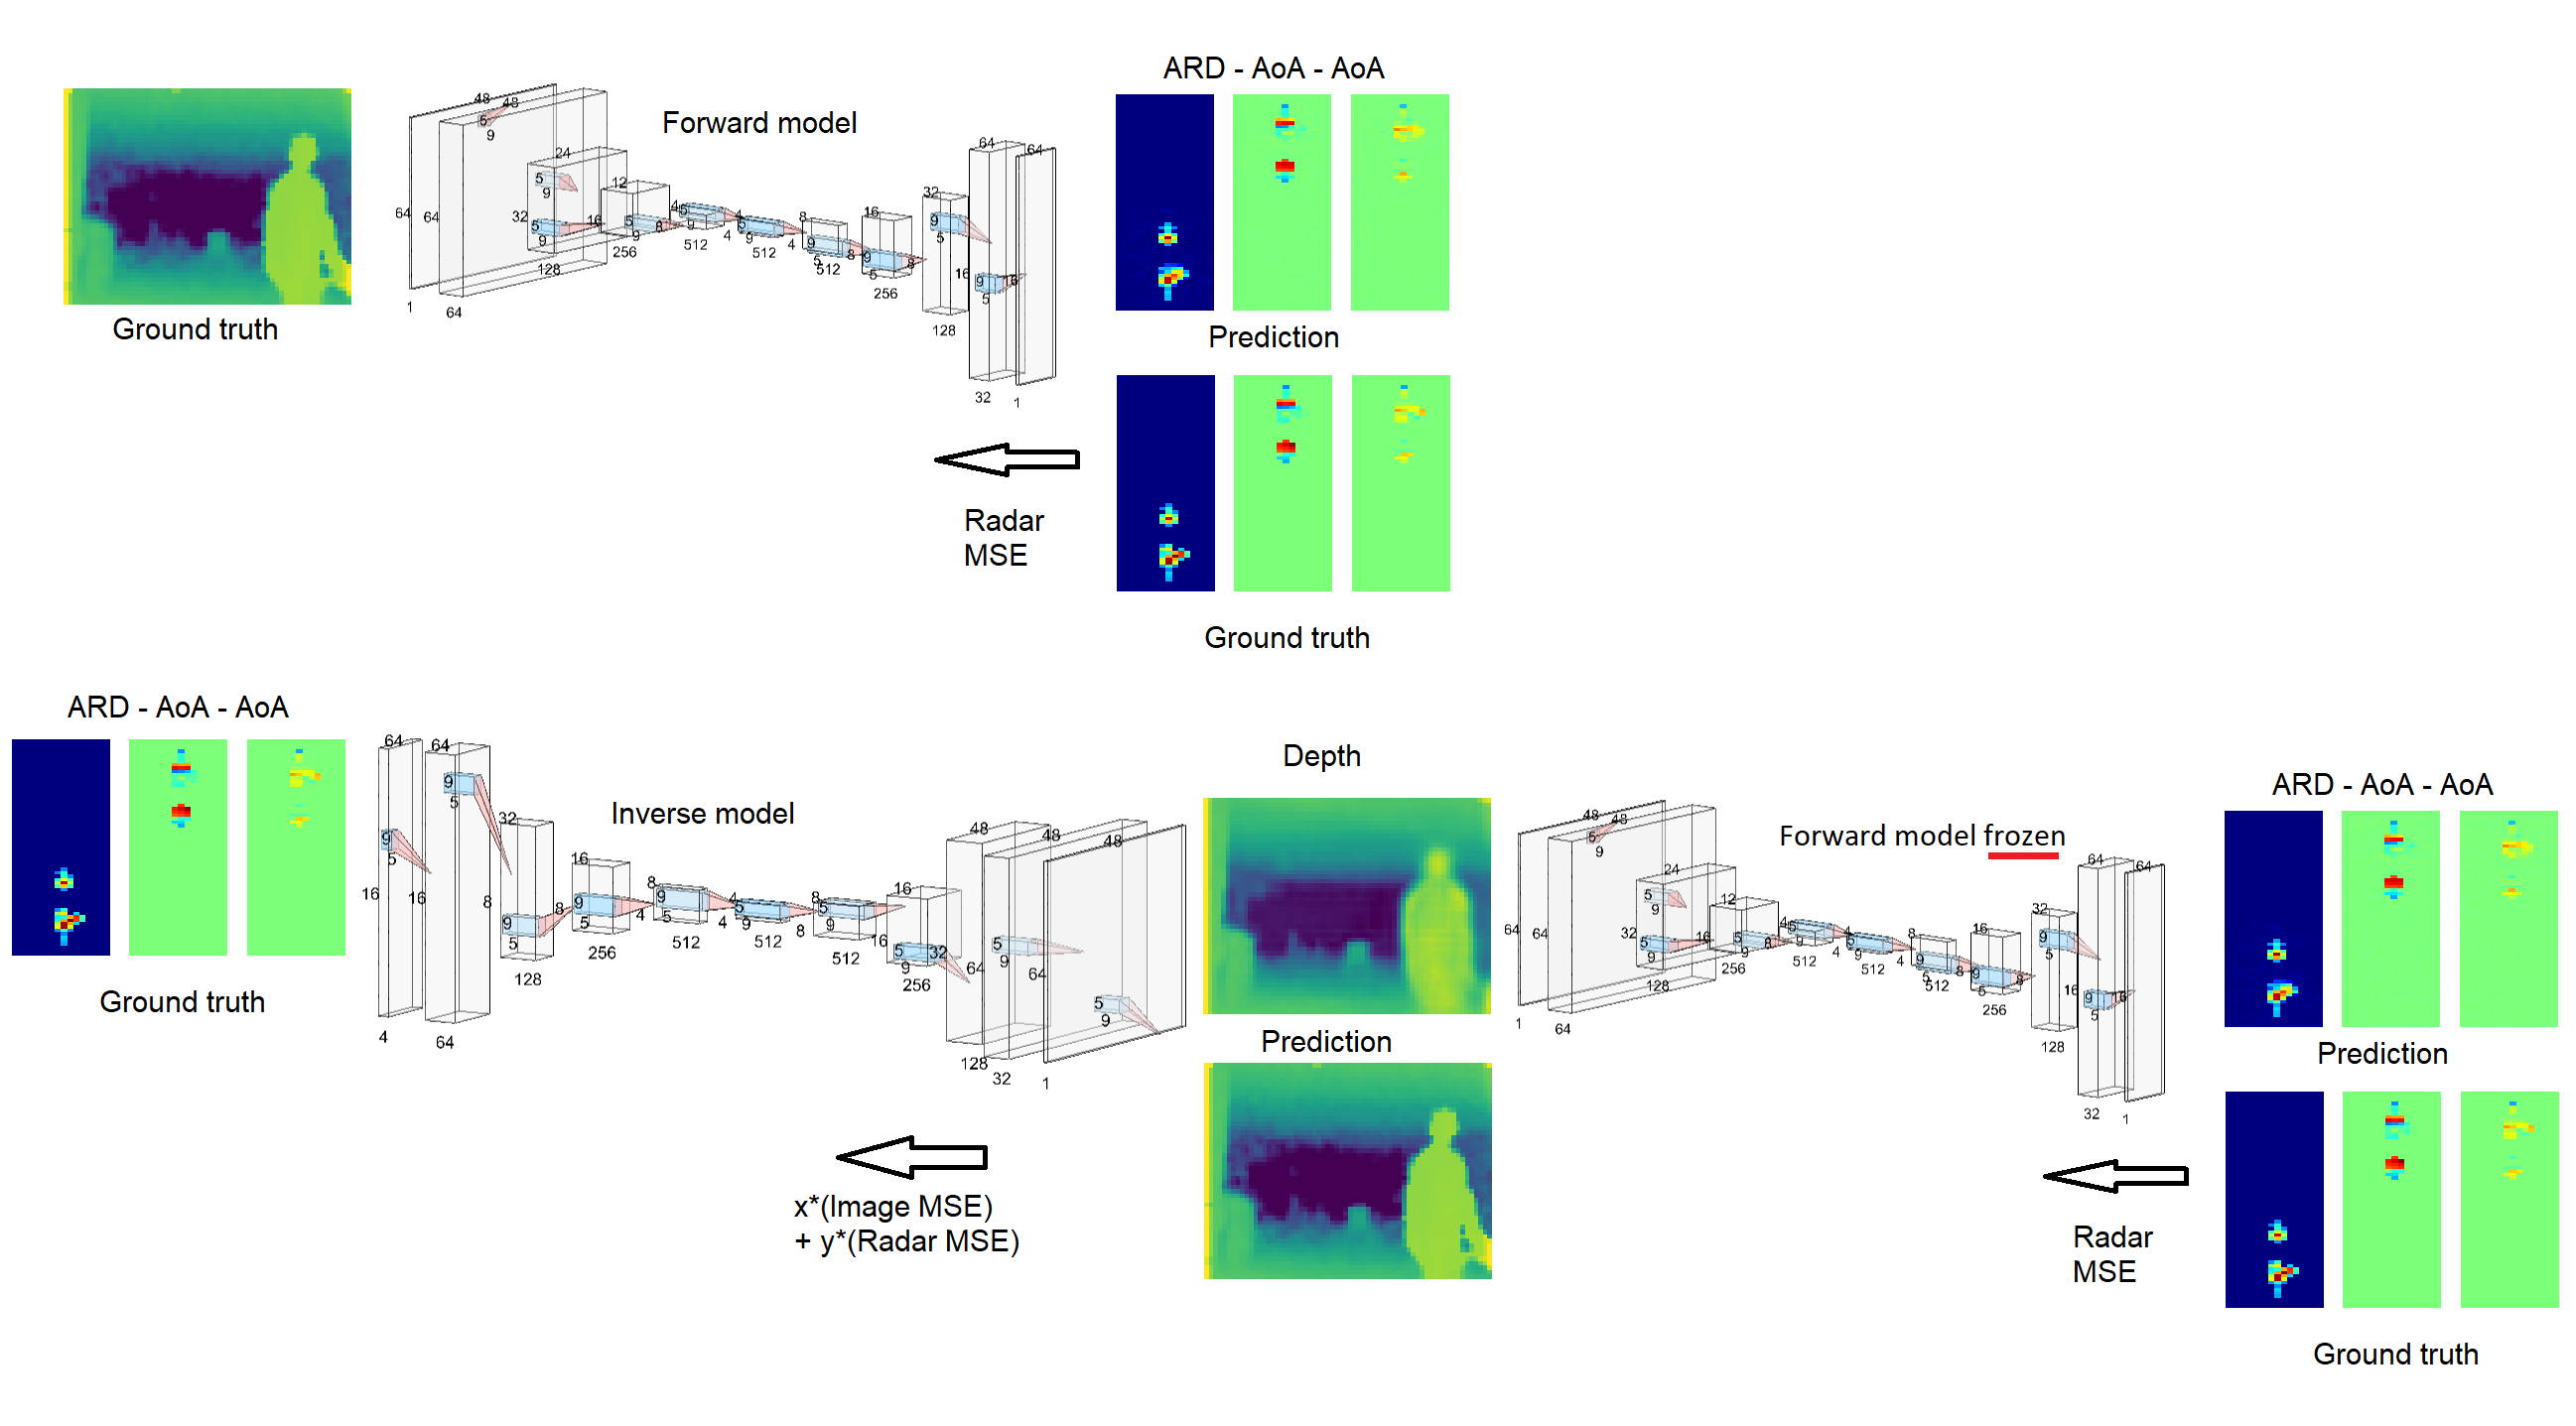

In [14]:
import inverse_forward_models_1
importlib.reload(inverse_forward_models_1)

IM = inverse_forward_models_1.inverse_model(soli_x_train[0].shape)     
FM = inverse_forward_models_1.forward_model(soli_y_train[0].shape)
IM.summary()
FM.summary()

adam = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
mean_squared_error = tf.keras.losses.MeanSquaredError()

def inverse_loss(radar_true, image_true):
    alpha = 10
    beta = 1
    FM.trainable = False
    forward_component = alpha*mean_squared_error(radar_true,FM(IM(radar_true)))
    inverse_component = beta*mean_squared_error(image_true,IM(radar_true))
    training_loss = forward_component + inverse_component
    return training_loss, forward_component, inverse_component #just tracking components, only use training_loss in backprop

def forward_loss(radar_true, image_true):
    return mean_squared_error(radar_true,FM(image_true))

@tf.function
def forward_train_step(radar_true, image_true):
    with tf.GradientTape() as forward_tape:
        FM_loss = forward_loss(radar_true, image_true)
    forward_gradients = forward_tape.gradient(FM_loss, FM.trainable_variables)
    adam.apply_gradients((zip(forward_gradients, FM.trainable_variables)))
    return FM_loss #just to track

@tf.function
def inverse_train_step(radar_true, image_true):
    with tf.GradientTape() as inverse_tape:
        IM_loss, forward_component, inverse_component = inverse_loss(radar_true, image_true) 
    inverse_gradients = inverse_tape.gradient(IM_loss, IM.trainable_variables)
    adam.apply_gradients((zip(inverse_gradients, IM.trainable_variables)))
    return IM_loss, forward_component, inverse_component 



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 64, 16)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 16)        8704      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 32, 8)        368768    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 128, 32, 8)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 16, 8)        1474816   
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256, 16, 8)        0   

## This is the training you are interested in (radar input, image output)

In [ ]:
forward_loss_log = []
def train_forward(x_train, y_train, batch_size, epochs):
    for epoch in range(epochs):
        start = time.time()
        for _ in tqdm(range(int(len(x_train)/batch_size))):
            #Select minibatch
            rand_nums = np.random.randint(0, len(x_train), size=batch_size)                
            radar_batch = x_train[rand_nums]
            image_batch = y_train[rand_nums]
            #Train
            forward_loss = forward_train_step(radar_batch,image_batch)
            display.clear_output(wait=True)
            tf.print('epoch {} batch {}: ---- fwd_loss {}'.format(epoch,_,forward_loss))
            #Logging
            forward_loss_log.append(forward_loss)
train_forward(soli_x_train.astype('float32'), soli_y_train.astype('float32'), batch_size = 150,epochs = 200)

epoch 153 batch 10: ---- fwd_loss 0.0566328763961792



 50%|█████████████████████████████████████████                                         | 11/22 [00:09<00:09,  1.11it/s]

In [ ]:
# fig=plt.figure(figsize=(5,3))
# plt.title('Training history')
# plt.plot(forward_loss_log,label='forward model training loss')
# plt.xlabel('Batch')
# plt.ylabel('MSE')
# plt.yscale('log')
# plt.legend()    
# plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\02_models\20210803_0_soli_irs_ard_aoa_400_epochs_inverse_forward\forward_training.png')

## You don't really care about this stuff below, yet

In [13]:
# tf.keras.utils.plot_model(FM, to_file=r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\02_models\20210803_0_soli_irs_ard_aoa_400_epochs_inverse_forward\forward_model_architecture.png',show_shapes=True) 
# FM.save(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\02_models\20210803_0_soli_irs_ard_aoa_400_epochs_inverse_forward\forward.h5')

In [13]:
FM = tf.keras.models.load_model(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\02_models\20210803_0_soli_irs_ard_aoa_400_epochs_inverse_forward\forward.h5')
FM.trainable=False
inverse_loss_log = []
inverse_fm_loss_log = [] # when training inverse model, this is the loss component from the forward model
inverse_im_loss_log = [] # when training inverse model, this is the loss component from the inverse model
def train_inverse(x_train, y_train, batch_size, epochs):
    for epoch in range(epochs):
        start = time.time()
        for _ in range(int(len(x_train)/batch_size)):
            #Select minibatch
            rand_nums = np.random.randint(0, len(x_train), size=batch_size)                
            radar_batch = x_train[rand_nums]
            image_batch = y_train[rand_nums]
            #Train
            inverse_loss, forward_component, inverse_component = inverse_train_step(radar_batch,image_batch)
            display.clear_output(wait=True)
            tf.print('epoch {} batch {}: ---- inv_loss {} fwd_component {} inv component {}'.format(epoch,_,inverse_loss,forward_component,inverse_component))
            #Logging
            inverse_loss_log.append(inverse_loss)
            inverse_fm_loss_log.append(forward_component)
            inverse_im_loss_log.append(inverse_component)
train_inverse(soli_x_train.astype('float32'), soli_y_train.astype('float32'), batch_size = 150,epochs = 200)

epoch 199 batch 52: ---- inv_loss 0.1314537227153778 fwd_component 0.12630583345890045 inv component 0.005147891119122505


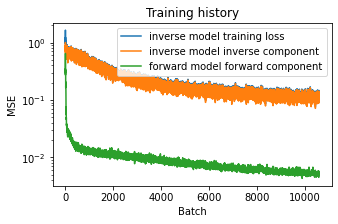

In [15]:
# fig=plt.figure(figsize=(5,3))
# plt.title('Training history')
# plt.plot(inverse_loss_log,label='inverse model training loss')
# plt.plot(inverse_fm_loss_log,label='inverse model inverse component')
# plt.plot(inverse_im_loss_log,label='forward model forward component')
# plt.xlabel('Batch')
# plt.ylabel('MSE')
# plt.yscale('log')
# plt.legend()    
# plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\02_models\20210803_0_soli_irs_ard_aoa_400_epochs_inverse_forward\inverse_training.png')

# IM.save(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\02_models\20210803_0_soli_irs_ard_aoa_400_epochs_inverse_forward\inverse.h5')

In [16]:
#model = tf.keras.models.load_model(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\02_models\{}_soli_irs_iq_400_epochs_hummingbird\soli_model_hummingbird.h5'.format(dataset,r'20210711'))
#model.load_weights(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\02_models\{}_soli_soli_irs_1\soli_model.h5'.format(dataset,date))

soli_predictions = IM.predict(soli_x_test,batch_size=10)
fm_predictions = FM.predict(soli_predictions)
#p2go_predictions = model.predict(p2go_x_test.transpose(0,2,1),batch_size=10).transpose(0,3,1,2)

print(soli_predictions.shape)
max_depth=9
mse_list = []
fm_ard_mse_list = []
fm_aoah_mse_list = []
fm_aoav_mse_list = []
ssim_list = []
for i in range(len(p2go_x_test)):
    mse_list.append(mean_squared_error(soli_y_test[i,0]*max_depth,soli_predictions[i,0]*max_depth))
    fm_ard_mse_list.append(mean_squared_error(soli_x_test[i,0],fm_predictions[i,0]))
    fm_aoah_mse_list.append(mean_squared_error(soli_x_test[i,1],fm_predictions[i,1]))
    fm_aoav_mse_list.append(mean_squared_error(soli_x_test[i,2],fm_predictions[i,2]))
    #ssim_list.append(tf.image.ssim(y_test[i,0]*max_depth,soli_predictions[i,0]*max_depth,1))
    #for j in range(soli_x_test.shape[1]):
        #mse_list.append(mean_squared_error(soli_y_test[i,j,0]*max_depth,soli_predictions[i,j,0]*max_depth))
        #ssim_list.append(tf.image.ssim(y_test[i,0,j]*max_depth,predictions[i,0,j]*max_depth,1))
mean_mse = np.mean(mse_list)
mean_ssim = np.mean(ssim_list)

print(mean_mse,mean_ssim)

(500, 1, 48, 64)
1.1059678 nan


C:\Users\kapit\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kapit\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


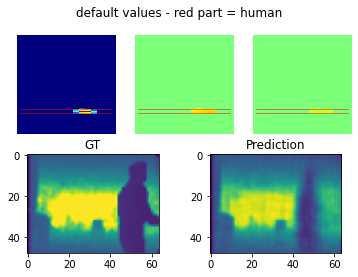

In [17]:
test_datapoint = soli_x_test[105].copy()
plt.suptitle('default values - red part = human')
plt.subplot(231)
plt.plot([0,15],[13,13],c='r',linewidth=0.5)
plt.plot([0,15],[16,16],c='r',linewidth=0.5)
plt.imshow(test_datapoint[0],vmin=0,vmax=1, origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(232)
plt.plot([0,15],[13,13],c='r',linewidth=0.5)
plt.plot([0,15],[16,16],c='r',linewidth=0.5)
plt.imshow(test_datapoint[1],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(233)
plt.plot([0,15],[13,13],c='r',linewidth=0.5)
plt.plot([0,15],[16,16],c='r',linewidth=0.5)
plt.imshow(test_datapoint[2],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(223)
plt.imshow(soli_y_test[0,0])
plt.title('GT')
plt.subplot(224)
plt.imshow(soli_predictions[0,0])
plt.title('Prediction')
plt.show()

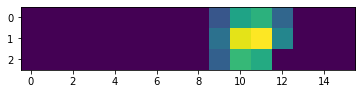

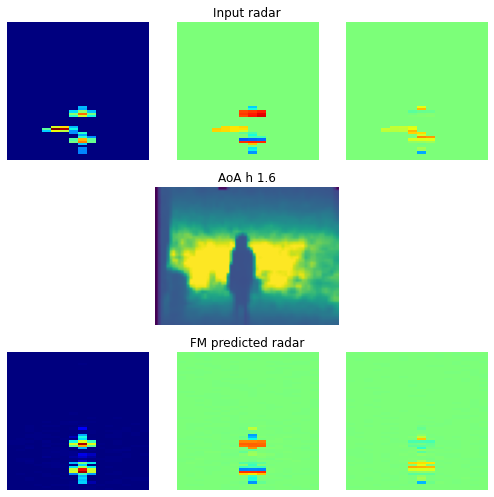

In [161]:
test_datapoint = soli_x_test[105].copy()
test_datapoint = soli_x_test[105].copy()#np.zeros_like(test_datapoint)
for i,io in enumerate(range(64)):
    for j,jo in enumerate((16)):
        test_data[]
#test_datapoint[:,:,1:] = soli_x_test[105].copy()[:,:,::-1][:,:,:15]
im_predict = IM.predict(test_datapoint.reshape(1,3,64,16))
fm_predict = FM.predict(im_predict).reshape(3,64,16)

plt.figure(figsize=(8.6,8.6))
plt.subplot(331)
plt.imshow(test_datapoint[0],vmin=0,vmax=1, origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(332)
plt.title('Input radar')
plt.imshow(test_datapoint[1],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(333)
plt.imshow(test_datapoint[2],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(312)
plt.imshow(im_predict[0,0])
plt.title('AoA h {:.2g}'.format(i))
plt.axis('off')
plt.subplot(337)
plt.imshow(fm_predict[0],vmin=0,vmax=1, origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(338)
plt.title('FM predicted radar')
plt.imshow(fm_predict[1],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(339)
plt.imshow(fm_predict[2],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.show()

C:\Users\kapit\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
C:\Users\kapit\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\kapit\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes usin

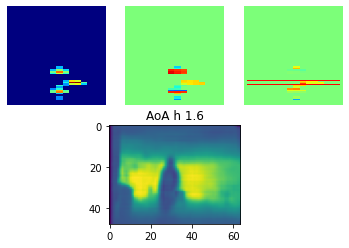

In [123]:
# test_datapoint = soli_x_test[105].copy()
# plt.imshow(test_datapoint[0,13:16])
# for co,i in enumerate(np.linspace(-np.pi/2,np.pi/2,50)):
#     test_datapoint[1,13:16] = i
#     fm_predict = IM.predict(test_datapoint.reshape(1,3,64,16))
#     plt.imshow(fm_predict[0,0])
#     plt.title('AoA_h {:.2g}'.format(i))
#     plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\03_results\20210729_0_soli_irs_ard_aoa_400_epochs_inverse_forward\tests\vary_aoa_h\img{}'.format(co))
        
test_datapoint = soli_x_test[105].copy()
plt.imshow(test_datapoint[0,13:16])
for co,i in enumerate(np.linspace(-np.pi/2,np.pi/2,50)):
    test_datapoint = soli_x_test[105].copy()
    test_datapoint[2,13:16] = i*test_datapoint[2,13:16]
    im_predict = IM.predict(test_datapoint.reshape(1,3,64,16))
    plt.subplot(231)
    plt.imshow(test_datapoint[0],vmin=0,vmax=1, origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(test_datapoint[1],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
    plt.axis('off')
    plt.subplot(233)
    plt.plot([0,15],[13,13],c='r',linewidth=0.5)
    plt.plot([0,15],[16,16],c='r',linewidth=0.5)
    plt.imshow(test_datapoint[2],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
    plt.axis('off')
    plt.subplot(212)
    plt.imshow(im_predict[0,0])
    plt.title('AoA h {:.2g}'.format(i))
    plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210721_timing_experiment\03_results\20210729_0_soli_irs_ard_aoa_400_epochs_inverse_forward\tests\vary_aoa_v\img{}'.format(co))
        

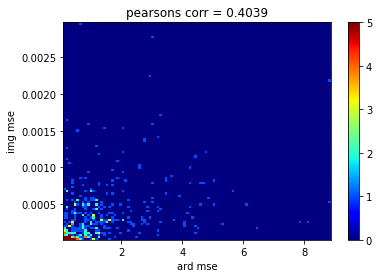

0.4039038330773086 4.8222608926987615e-21


In [64]:
%matplotlib inline
from scipy.stats import pearsonr 
corr, _ = pearsonr(mse_list,fm_ard_mse_list)
plt.hist2d(mse_list, fm_ard_mse_list, vmax=5, bins=[100,100], cmap='jet')
plt.title('pearsons corr = {}'.format(np.round_(corr,4)))
plt.xlabel('ard mse')
plt.ylabel('img mse')
#plt.xlim([0,0.5])
plt.colorbar()
plt.show()
print(corr,_)

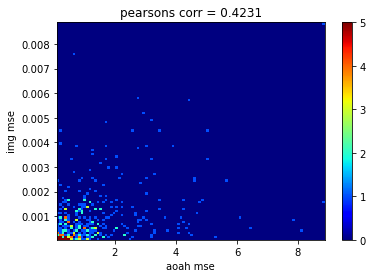

0.42308085918952515 3.931642056951669e-23


In [68]:
%matplotlib inline
from scipy.stats import pearsonr 
corr, _ = pearsonr(mse_list,fm_aoah_mse_list)
plt.hist2d(mse_list, fm_aoah_mse_list, vmax=5, bins=[100,100], cmap='jet')
plt.title('pearsons corr = {}'.format(np.round_(corr,4)))
plt.xlabel('aoah mse')
plt.ylabel('img mse')
#plt.xlim([0,0.5])
plt.colorbar()
plt.show()
print(corr,_)

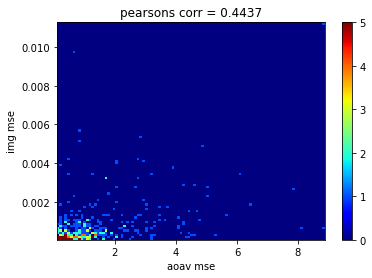

0.4437466125848699 1.5439993595122256e-25


In [69]:
%matplotlib inline
from scipy.stats import pearsonr 
corr, _ = pearsonr(mse_list,fm_aoav_mse_list)
plt.hist2d(mse_list, fm_aoav_mse_list, vmax=5, bins=[100,100], cmap='jet')
plt.title('pearsons corr = {}'.format(np.round_(corr,4)))
plt.xlabel('aoav mse')
plt.ylabel('img mse')
#plt.xlim([0,0.5])
plt.colorbar()
plt.show()
print(corr,_)

In [188]:
print(fm_predictions[0,0])

[[-1.5424668e-05 -3.2583896e-05  1.6361225e-04 ... -4.1407367e-04
  -8.3643908e-04 -6.3858496e-04]
 [-7.5667835e-05  1.1815096e-05 -6.9331973e-06 ... -9.8866958e-04
  -1.3890626e-03 -1.0299404e-03]
 [-3.9699386e-04 -2.1539295e-04 -2.6653294e-07 ... -6.6269090e-04
  -1.2209048e-03 -7.5054914e-04]
 ...
 [ 2.6453486e-05 -6.0438331e-05 -2.8966152e-04 ... -2.6916366e-04
  -1.5827517e-04 -1.8264698e-04]
 [ 2.0123106e-04  5.4412332e-05 -3.7354490e-04 ... -2.2206284e-05
   5.2915857e-05  9.1009220e-05]
 [-2.6700951e-05 -2.8619741e-04 -4.7628046e-04 ... -1.9682010e-04
  -2.4362620e-04 -1.8844134e-04]]


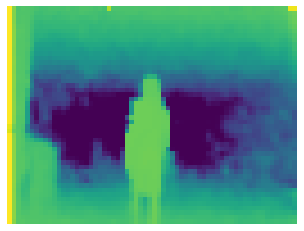

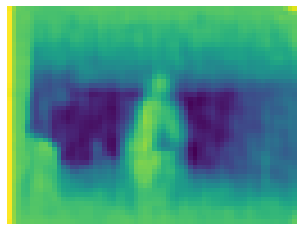

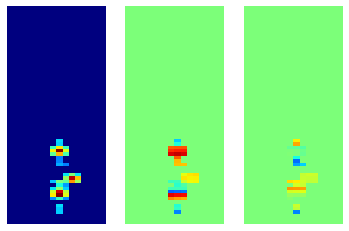

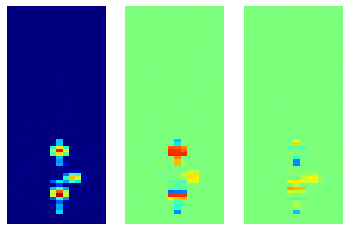

In [201]:
co = 102
plt.imshow(soli_y_test[co,0],cmap='viridis_r')
plt.axis('off')
plt.show()
plt.imshow(soli_predictions[co,0], cmap='viridis_r')
plt.axis('off')
plt.show()
plt.subplot(131)
plt.imshow(soli_x_test[co,0],origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(132)
plt.imshow(soli_x_test[co,1],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(133)
plt.imshow(soli_x_test[co,2],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
#plt.savefig()
plt.show()
plt.subplot(131)
plt.imshow(fm_predictions[co,0],vmin=0,vmax=1, origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(132)
plt.imshow(fm_predictions[co,1],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.subplot(133)
plt.imshow(fm_predictions[co,2],cmap='jet',origin='lower',vmin=-np.pi/2,vmax=np.pi/2,interpolation='none', aspect='auto')
plt.axis('off')
plt.show()

In [ ]:
# for co in range(len(x_test)):
#     plt.figure(figsize=(8.4,2.4),dpi=100)
#     plt.subplot(131)
#     plt.plot(x_test[co,:].T)
#     plt.xlabel('range (m)')
#     plt.title('RP')
#     plt.ylabel('amplitude (a.u.)')
#     plt.xticks(ticks = [0, 40], labels=rang[[64,64+40]])
#     plt.subplot(132)
#     plt.imshow(predictions[co,0])
#     plt.title('prediction')
#     plt.subplot(133)
#     plt.title('ground truth')
#     plt.imshow(np.abs(y_test[co,0]))
#     plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_{}_{}_mse\img{}.png'.format(dataset,date,architecture,input_format,co),bbox_inches='tight')
#     plt.close()
#     plt.show()

In [ ]:
#3D iq-data

for vid in range(len(x_test)):
    for co in range(x_test.shape[1]):
        plt.figure(figsize=(12.8,2.4),dpi=100)
        plt.subplot(1,3,1)
        plt.title('I/Q')
        plt.plot(x_test[vid,co,0].astype('float32'), label='ch 0')
        plt.plot(x_test[vid,co,1].astype('float32'), label='ch 1')
        plt.plot(x_test[vid,co,2].astype('float32'), label='ch 2')
        plt.xlabel('Sample')
        plt.ylabel('I/Q (a.u.)')
        #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
        #plt.tight_layout()        
        plt.legend()
        plt.subplot(1,3,2)
        plt.title('Ground truth')
        plt.imshow(max_depth*y_test[vid,co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
        cbar = plt.colorbar()
        cbar.set_label('depth (m)',rotation=270, labelpad=15)
        #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
        plt.subplot(1,3,3)
        plt.title('Prediction')
        plt.imshow(max_depth*predictions[vid,co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
        cbar = plt.colorbar()
        cbar.set_label('depth (m)',rotation=270, labelpad=15)
        #plt.legend(bbox_to_anchor=(1, 1.5))
        plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_{}_{}_no_declutter_mse\img{}.png'.format(dataset,date,architecture,input_format,vid*x_test.shape[1]+co),bbox_inches='tight')
        plt.close()
        #plt.show()    

In [45]:
# iq-data

for vid in range(len(p2go_x_test)):
    print(vid)
    gs = gridspec.GridSpec(1,3,bottom=0.2)
    plt.figure(figsize=(12.8,2.4),dpi=100)
    plt.subplot(gs[0])
    plt.title('I/Q')
    plt.plot(p2go_x_test[vid,0].astype('float32'), label='ch 0 i')
    plt.plot(p2go_x_test[vid,1].astype('float32'), label='ch 0 q')
    plt.plot(p2go_x_test[vid,2].astype('float32'), label='ch 1 i')
    plt.plot(p2go_x_test[vid,3].astype('float32'), label='ch 1 q')
    plt.xlabel('Sample')
    plt.ylabel('amplitude (a.u.)')
    plt.legend(loc=1)
    plt.subplot(gs[1])
    plt.title('Ground truth')
    plt.imshow(max_depth*p2go_y_test[vid,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
    plt.subplot(gs[2])
    plt.title('Prediction')
    plt.imshow(max_depth*p2go_predictions[vid,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    #plt.legend(bbox_to_anchor=(1, 1.5))
    plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_0_p2go_irs_iq_400_epochs_hummingbird\img{}.png'.format(dataset,date,vid))
    plt.close()
    #plt.show()    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
# soli vs p2go iq-data

for vid in range(len(soli_x_test)):
    print(vid)
    gs = gridspec.GridSpec(1,3,bottom=0.2)
    plt.figure(figsize=(12.8,2.4),dpi=100)
    plt.subplot(gs[0])
    plt.title('Ground truth')
    plt.imshow(max_depth*y_test[vid,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none',aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    plt.subplot(gs[1])
    plt.title('SOLI prediction')
    plt.imshow(max_depth*soli_predictions[vid,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none',aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
    plt.subplot(gs[2])
    plt.title('P2Go prediction')
    plt.imshow(max_depth*p2go_predictions[vid,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none',aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    #plt.legend(bbox_to_anchor=(1, 1.5))
    plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_soli_p2go_400_epochs_hummingbird\img{}.png'.format(dataset,date,vid))
    plt.close()
    #plt.show()    

In [18]:
# ard-aoa-aoa data
x_test = soli_x_test.copy()
rang = soli_rang.copy()
vel = soli_vel.copy()
date = '20210803'
for vid in range(len(x_test)):
    amp2 = x_test[vid, 0].copy()
    t_ranges = rang[np.where(amp2>0)[0]+64]
    t_angle_v = x_test[vid,2][amp2>0]
    t_angle_h = x_test[vid,1][amp2>0]
    h,v = utils.angle2pixel(t_angle_h,t_angle_v)

    fig = plt.figure(figsize = (8.53,7.2), dpi=100)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    for channel_id,channel_name in enumerate(['ARD Rx2','AoA horizontal', 'AoA vertical']):  
        plt.subplot(3, 3, (channel_id + 1))
        if 'AoA' not in channel_name:
            plt.imshow(soli_x_test[vid, channel_id], origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
        elif 'AoA' in channel_name:
            plt.imshow(soli_x_test[vid, channel_id], origin='lower', vmin=-np.pi/2, vmax=np.pi/2, cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
        plt.title(channel_name)
        plt.xlabel('velocity (m/s)')
        plt.xticks(ticks = [0,4,8,12],labels=vel[[0,4,8,12]])
        plt.ylabel('range (m)')
        plt.yticks(ticks = [0, 20, 40, 60], labels=rang[[64,64+20,64+40,63+60]])
        cbar = plt.colorbar()
        cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=10)
        plt.axis('off')
    for channel_id,channel_name in enumerate(['FM ARD mean','FM AoA hori.', 'FM AoA vert.']):  
        plt.subplot(3, 3, (channel_id + 1+3))
        if 'AoA' not in channel_name:
            plt.imshow(fm_predictions[vid, channel_id], origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto', vmin=0, vmax=1)
        elif 'AoA' in channel_name:
            plt.imshow(fm_predictions[vid, channel_id], origin='lower', vmin=-np.pi/2, vmax=np.pi/2, cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
        plt.title('{}, MSE {:.2g}'.format(channel_name, mean_squared_error(soli_x_test[vid,channel_id],fm_predictions[vid,0]),4))
        plt.xlabel('velocity (m/s)')
        plt.xticks(ticks = [0,4,8,12],labels=vel[[0,4,8,12]])
        plt.ylabel('range (m)')
        plt.yticks(ticks = [0, 20, 40, 60], labels=rang[[64,64+20,64+40,63+60]])
        cbar = plt.colorbar()
        if 'AoA' not in channel_name:
            cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=10)
        elif 'AoA' in channel_name:
             cbar.set_label('angle (rad)',rotation=270,labelpad=10)
        plt.axis('off')
    #plt.tight_layout()        
    plt.subplot(3,2,5)
    plt.title('Ground truth')
    plt.imshow(max_depth*soli_y_test[vid, 0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    plt.axis('off')
    #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
    plt.subplot(3,2,6)
    plt.title('IM prediction, MSE {:.2g}'.format(mean_squared_error(soli_y_test[vid,0]*max_depth,soli_predictions[vid,0]*max_depth)))
    plt.imshow(max_depth*soli_predictions[vid, 0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('depth (m)',rotation=270, labelpad=15)
    plt.axis('off')
    #plt.legend(bbox_to_anchor=(1, 1.5))
    plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_0_soli_irs_ard_aoa_400_epochs_inverse_forward\img{}.png'.format(dataset,date,vid))
    plt.close()
    #plt.show()    

In [58]:
#3D ard-aoa-aoa data
x_test = soli_x_test.copy()
rang = soli_rang.copy()
vel = soli_vel.copy()

for vid in range(len(x_test)):
    for co in range(x_test.shape[1]):
        amp2 = x_test[vid,co,0].copy()
        t_ranges = rang[np.where(amp2>0)[0]+64]
        t_angle_v = x_test[vid,co,2][amp2>0]
        t_angle_h = x_test[vid,co,1][amp2>0]
        h,v = utils.angle2pixel(t_angle_h,t_angle_v)

        fig = plt.figure(figsize = (8.53,4.8), dpi=100)
        plt.subplots_adjust(hspace=0.5,wspace=1)
        for channel_id,channel_name in enumerate(['ARD Rx2','AoA horizontal', 'AoA vertical']):  
            plt.subplot(2, 3, (channel_id + 1))
            if 'AoA' not in channel_name:
                plt.imshow(x_test[vid,co,channel_id], origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
            elif 'AoA' in channel_name:
                plt.imshow(x_test[vid,co,channel_id], origin='lower', vmin=-np.pi/2, vmax=np.pi/2, cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
            plt.title(channel_name)
            plt.xlabel('velocity (m/s)')
            plt.xticks(ticks = [0,4,8,12],labels=vel[[0,4,8,12]])
            plt.ylabel('range (m)')
            plt.yticks(ticks = [0, 20, 40, 60], labels=rang[[63,63+20,63+40,63+60]])
            cbar = plt.colorbar()
            cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=10)
        #plt.tight_layout()        
        plt.subplot(2,2,3)
        plt.title('Ground truth')
        plt.imshow(max_depth*y_test[vid,co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none')
        cbar = plt.colorbar()
        cbar.set_label('depth (m)',rotation=270, labelpad=15)
        #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
        plt.subplot(2,2,4)
        plt.title('Prediction vs radar signal')
        plt.imshow(max_depth*soli_predictions[vid,co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
        cbar = plt.colorbar()
        cbar.set_label('depth (m)',rotation=270, labelpad=15)
        #plt.legend(bbox_to_anchor=(1, 1.5))
        print(vid,co,vid*x_test.shape[1]+co)
        plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_0_soli_irs_3d_ard_aoa_400_epochs_hummingbird\img{}.png'.format(dataset,date,vid*x_test.shape[1]+co))
        plt.close()
        #plt.show()    

0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
1 0 10
1 1 11
1 2 12
1 3 13
1 4 14
1 5 15
1 6 16
1 7 17
1 8 18
1 9 19
2 0 20
2 1 21
2 2 22
2 3 23
2 4 24
2 5 25
2 6 26
2 7 27
2 8 28
2 9 29
3 0 30
3 1 31
3 2 32
3 3 33
3 4 34
3 5 35
3 6 36
3 7 37
3 8 38
3 9 39
4 0 40
4 1 41
4 2 42
4 3 43
4 4 44
4 5 45
4 6 46
4 7 47
4 8 48
4 9 49
5 0 50
5 1 51
5 2 52
5 3 53
5 4 54
5 5 55
5 6 56
5 7 57
5 8 58
5 9 59
6 0 60
6 1 61
6 2 62
6 3 63
6 4 64
6 5 65
6 6 66
6 7 67
6 8 68
6 9 69
7 0 70
7 1 71
7 2 72
7 3 73
7 4 74
7 5 75
7 6 76
7 7 77
7 8 78
7 9 79
8 0 80
8 1 81
8 2 82
8 3 83
8 4 84
8 5 85
8 6 86
8 7 87
8 8 88
8 9 89
9 0 90
9 1 91
9 2 92
9 3 93
9 4 94
9 5 95
9 6 96
9 7 97
9 8 98
9 9 99
10 0 100
10 1 101
10 2 102
10 3 103
10 4 104
10 5 105
10 6 106
10 7 107
10 8 108
10 9 109
11 0 110
11 1 111
11 2 112
11 3 113
11 4 114
11 5 115
11 6 116
11 7 117
11 8 118
11 9 119
12 0 120
12 1 121
12 2 122
12 3 123
12 4 124
12 5 125
12 6 126
12 7 127
12 8 128
12 9 129
13 0 130
13 1 131
13 2 132
13 3 133
13 4

NameError: name 'p2go_predictions' is not defined

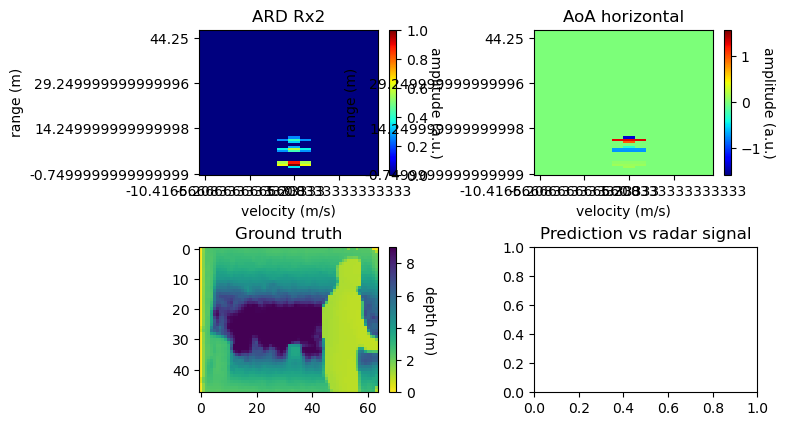

In [57]:
#3D ard-aoa data
x_test = p2go_x_test.copy()
rang = p2go_rang.copy()
vel = p2go_vel.copy()

for vid in range(len(x_test)):
    for co in range(x_test.shape[1]):
        amp2 = x_test[vid,co,0].copy()
        t_ranges = rang[np.where(amp2>0)[0]+64]
        t_angle_h = x_test[vid,co,1][amp2>0]

        fig = plt.figure(figsize = (7.2,4.8), dpi=100)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
        for channel_id,channel_name in enumerate(['ARD Rx2','AoA horizontal']):  
            plt.subplot(2, 2, (channel_id + 1))
            if 'AoA' not in channel_name:
                plt.imshow(x_test[vid,co,channel_id], origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
            elif 'AoA' in channel_name:
                plt.imshow(x_test[vid,co,channel_id], origin='lower', vmin=-np.pi/2, vmax=np.pi/2, cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
            plt.title(channel_name)
            plt.xlabel('velocity (m/s)')
            plt.xticks(ticks = [0,4,8,12],labels=vel[[0,4,8,12]])
            plt.ylabel('range (m)')
            plt.yticks(ticks = [0, 20, 40, 60], labels=rang[[63,63+20,63+40,63+60]])
            cbar = plt.colorbar()
            cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=10)
        #plt.tight_layout()        
        plt.subplot(2,2,3)
        plt.title('Ground truth')
        plt.imshow(max_depth*y_test[vid,co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
        cbar = plt.colorbar()
        cbar.set_label('depth (m)',rotation=270, labelpad=15)
        #plt.scatter(h,v,c=t_ranges,vmin=0,vmax=max_depth,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
        plt.subplot(2,2,4)
        plt.title('Prediction vs radar signal')
        plt.imshow(max_depth*p2go_predictions[vid,co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
        cbar = plt.colorbar()
        cbar.set_label('depth (m)',rotation=270, labelpad=15)
        #plt.legend(bbox_to_anchor=(1, 1.5))
        print(vid,co,vid*x_test.shape[1]+co)
        plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\{}\03_results\{}_0_p2go_irs_3d_ard_aoa_400_epochs_hummingbird\img{}.png'.format(dataset,date,vid*x_test.shape[1]+co))
        plt.close()
        #plt.show()    

In [ ]:
vid = 5

plt.figure(figsize=(14.4,2.4),dpi=100)
gs = gridspec.GridSpec(1,5,width_ratios=[1,1,1,1,3],wspace=0.8,hspace=0.8)

plt.subplot(gs[0])
plt.plot(soli_iq[vid,0],label='ch0')
#cbar.ax.tick_params(direction='in')
plt.yticks(fontname='Arial',fontsize=14)
plt.xticks(ticks=[0,64,128],labels=[int(0),int(64*500/128),int(128*500/128)],fontname='Arial',fontsize=14)
plt.tick_params(direction='in')
plt.xlabel(r'time ($\mu$s)',fontname='Arial',fontsize=14,labelpad=0)
plt.ylabel(r'power (a.u.)',fontname='Arial',fontsize=14,labelpad=0)
plt.title('In-phase',fontname='Arial',fontsize=14)

plt.subplot(gs[1])
plt.plot(np.abs(soli_rp[vid,0]),label='ch0')
plt.yticks(fontname='Arial',fontsize=14)
plt.xticks(ticks=[0,32,64],labels=[soli_rang[64],soli_rang[63+32],soli_rang[63+64]],fontname='Arial',fontsize=14)
plt.tick_params(direction='in')
plt.xlabel(r'range (m)',fontname='Arial',fontsize=14,labelpad=0)
plt.ylabel(r'amplitude (a.u.)',fontname='Arial',fontsize=14,labelpad=0)
plt.title('Range profile',fontname='Arial',fontsize=14)

plt.subplot(gs[2])
plt.imshow(np.abs(soli_crd[vid,0]),label='ch0',origin='lower',cmap='jet',aspect='auto')
plt.yticks(fontname='Arial',fontsize=14)
plt.xticks(ticks=[0,8],labels=[soli_vel[0],int(soli_vel[8])],fontname='Arial',fontsize=14)
plt.yticks(ticks=[0,32,64],labels=[soli_rang[64],soli_rang[63+32],soli_rang[63+64]],fontname='Arial',fontsize=14)
plt.tick_params(direction='in')
plt.xlabel(r'velocity ($ms^{-1}$)',fontname='Arial',fontsize=14,labelpad=0)
plt.ylabel(r'range (m)',fontname='Arial',fontsize=14,labelpad=0)
plt.title('Absolute \nrange-doppler',fontname='Arial',fontsize=14)
cbar=plt.colorbar()
cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=12, fontname='Arial',fontsize=14)
cbar.ax.tick_params(direction='in')

plt.subplot(gs[3])
angle_image = soli_aoa[vid,0]
angle_image[np.abs(soli_crd[vid,0])<0.1]=0
plt.imshow(angle_image,label='ch0',vmin=-np.pi/2,vmax=np.pi/2,origin='lower',cmap='jet',aspect='auto')
plt.yticks(fontname='Arial',fontsize=14)
plt.xticks(ticks=[0,8],labels=[soli_vel[0],int(soli_vel[8])],fontname='Arial',fontsize=14)
plt.yticks(ticks=[0,32,64],labels=[soli_rang[64],soli_rang[63+32],soli_rang[63+64]],fontname='Arial',fontsize=14)
plt.tick_params(direction='in')
plt.xlabel(r'velocity ($ms^{-1}$)',fontname='Arial',fontsize=14,labelpad=0)
plt.ylabel(r'range (m)',fontname='Arial',fontsize=14,labelpad=0)
plt.title('Horizontal\nangle of arrival',fontname='Arial',fontsize=14)
cbar=plt.colorbar()
cbar.set_label('angle (rad)',rotation=270,labelpad=10, fontname='Arial',fontsize=14)
cbar.ax.tick_params(direction='in')

plt.subplot(gs[4])
im=plt.imshow(images[vid],cmap='viridis_r')
plt.tick_params(direction='in')
im_ratio = images[vid].shape[0]/images[vid].shape[1] 
cbar=plt.colorbar(im,fraction=0.048*im_ratio,pad=0.02)
cbar.set_label('depth (m)',rotation=270,labelpad=12, fontname='Arial',fontsize=14)
cbar.ax.tick_params(direction='in')
plt.title('Depth image',fontname='Arial',fontsize=14)
plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\reporting\2021_06_07_WP2_report\figs\fig3.svg',bbox_inches='tight')

In [ ]:
print(images.shape)

In [ ]:
print(soli_iq.shape)

In [ ]:
# for co in range(250):
#     amp2 = x_test[co,0].copy()
#     t_ranges = rang[np.where(amp2>0)[0]+64]
#     t_angle_v = x_test[co,2][amp2>0]
#     t_angle_h = x_test[co,1][amp2>0]
#     h,v = utils.angle2pixel(t_angle_h,t_angle_v)
    
#     fig = plt.figure(figsize = (8.53,4.8), dpi=100)
#     plt.subplots_adjust(hspace=0.5,wspace=1)
#     for channel_id,channel_name in enumerate(['ARD Rx2','AoA horizontal', 'AoA vertical']):  
#         plt.subplot(2, 3, (channel_id + 1))
#         if 'AoA' not in channel_name:
#             plt.imshow(x_test[co,channel_id], origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
#         elif 'AoA' in channel_name:
#             plt.imshow(x_test[co,channel_id], origin='lower', vmin=-np.pi/2, vmax=np.pi/2, cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
#         plt.title(channel_name)
#         plt.xlabel('velocity (m/s)')
#         plt.xticks(ticks = [0,4,8,12],labels=vel[[0,4,8,12]])
#         plt.ylabel('range (m)')
#         plt.yticks(ticks = [0, 20, 40, 60], labels=rang[[63,63+20,63+40,63+60]])
#         cbar = plt.colorbar()
#         cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=10)
#     #plt.tight_layout()        
#     plt.subplot(2,2,3)
#     plt.title('Ground truth')
#     plt.imshow(max_depth*y_test[co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
#     cbar = plt.colorbar()
#     cbar.set_label('depth (m)',rotation=270, labelpad=15)
#     plt.subplot(2,2,4)
#     plt.title('Prediction vs radar signal')
#     plt.imshow(max_depth*predictions[co,0].astype('float32'), vmin=0, vmax=max_depth, cmap='viridis_r', interpolation='none', aspect='auto')
#     cbar = plt.colorbar()
#     cbar.set_label('depth (m)',rotation=270, labelpad=15)
#     plt.scatter(h,v,c=t_ranges,vmin=0,vmax=7,edgecolors='k',cmap='viridis_r',marker='s',s=100*(amp2[amp2>0]))
#     #plt.legend(bbox_to_anchor=(1, 1.5))
#     plt.savefig(r'C:\Users\kapit\OneDrive - University of Glasgow\Single_pixel_detector\Radar_Google\data\20210409_soli_intelrealsense\03_results\cnn_v1_ard-aoa-aoa\img{}.png'.format(co))
#     plt.close()
#     #plt.show()    